# Curso de Manejo de Datos Faltantes: Imputacion

## Configuracion de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt

## Importar librerias

In [220]:
import janitor  #limpieza de datos
import matplotlib.pyplot as plt #visualizar datos
import missingno    #explorar missings
import nhanes.load  #dataframe del cual importaremos los datos
import numpy as np  #calculos numerios con df
import pandas as pd #manejo de df
import scipy.stats  #para realizar estadisticos
import seaborn as sns   #visualizacion estadistica
import session_info #ver que paquetes tenemos
import sklearn.compose  #cotiene todos los modelos y submodulos para hacer imputacion sencilla a missings
import sklearn.impute   
import sklearn.preprocessing
import statsmodels.api as sm    #crearemos modelos y accederemos a conjunto de datos de prueba
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [221]:
%run pandas-missing-extension.ipynb

## configurar el aspecto generarl de las graficas del proyecto

In [222]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")
sns.set_style("whitegrid")

## El problema de trabajar con valres faltantes

In [223]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")  #accedesmos a un df que provee statmodels que provienen de R
    .data
)

airquality_df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [224]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")  #accedesmos a un df que provee statmodels que provienen de R
    .data
    .clean_names(   #arreglamos nombres de variables
        case_type = "snake"
    )
    .add_column("year", 1973)   #añadimos variable/columna year
    .assign(    #añadimos variable/columna date, convirtiendo variable a fecha, con datos en formato year-month-day
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")   #ordenamos df por variable date
    .set_index("date")  #ponemos com indice del df a variable date
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


#### Ajustamos modelos de regresion lineal

In [225]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Sat, 20 Jan 2024",Prob (F-statistic):,2.93e-18
Time:,22:53:04,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [226]:
#consideramos variable adicional
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Sat, 20 Jan 2024",Prob (F-statistic):,1.47e-16
Time:,22:53:04,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


#### Reto: Datos de supervivientes

In [227]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [228]:
#consideramos variable adicional
(
    smf.ols(
        formula="death ~ age + chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide

Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-134.5
Date:,"Sat, 20 Jan 2024",Prob (F-statistic):,1.00
Time:,22:53:05,Log-Likelihood:,65649.
No. Observations:,2169,AIC:,-1.313e+05
Df Residuals:,2152,BIC:,-1.312e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


In [229]:
#consideramos variable adicional
(
    smf.ols(
        formula="death ~ futime + chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in scalar divide

Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-134.5
Date:,"Sat, 20 Jan 2024",Prob (F-statistic):,1.00
Time:,22:53:05,Log-Likelihood:,62644.
No. Observations:,2169,AIC:,-1.253e+05
Df Residuals:,2152,BIC:,-1.252e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


## Preparando datos: National Health and Nutrition Examination Survey

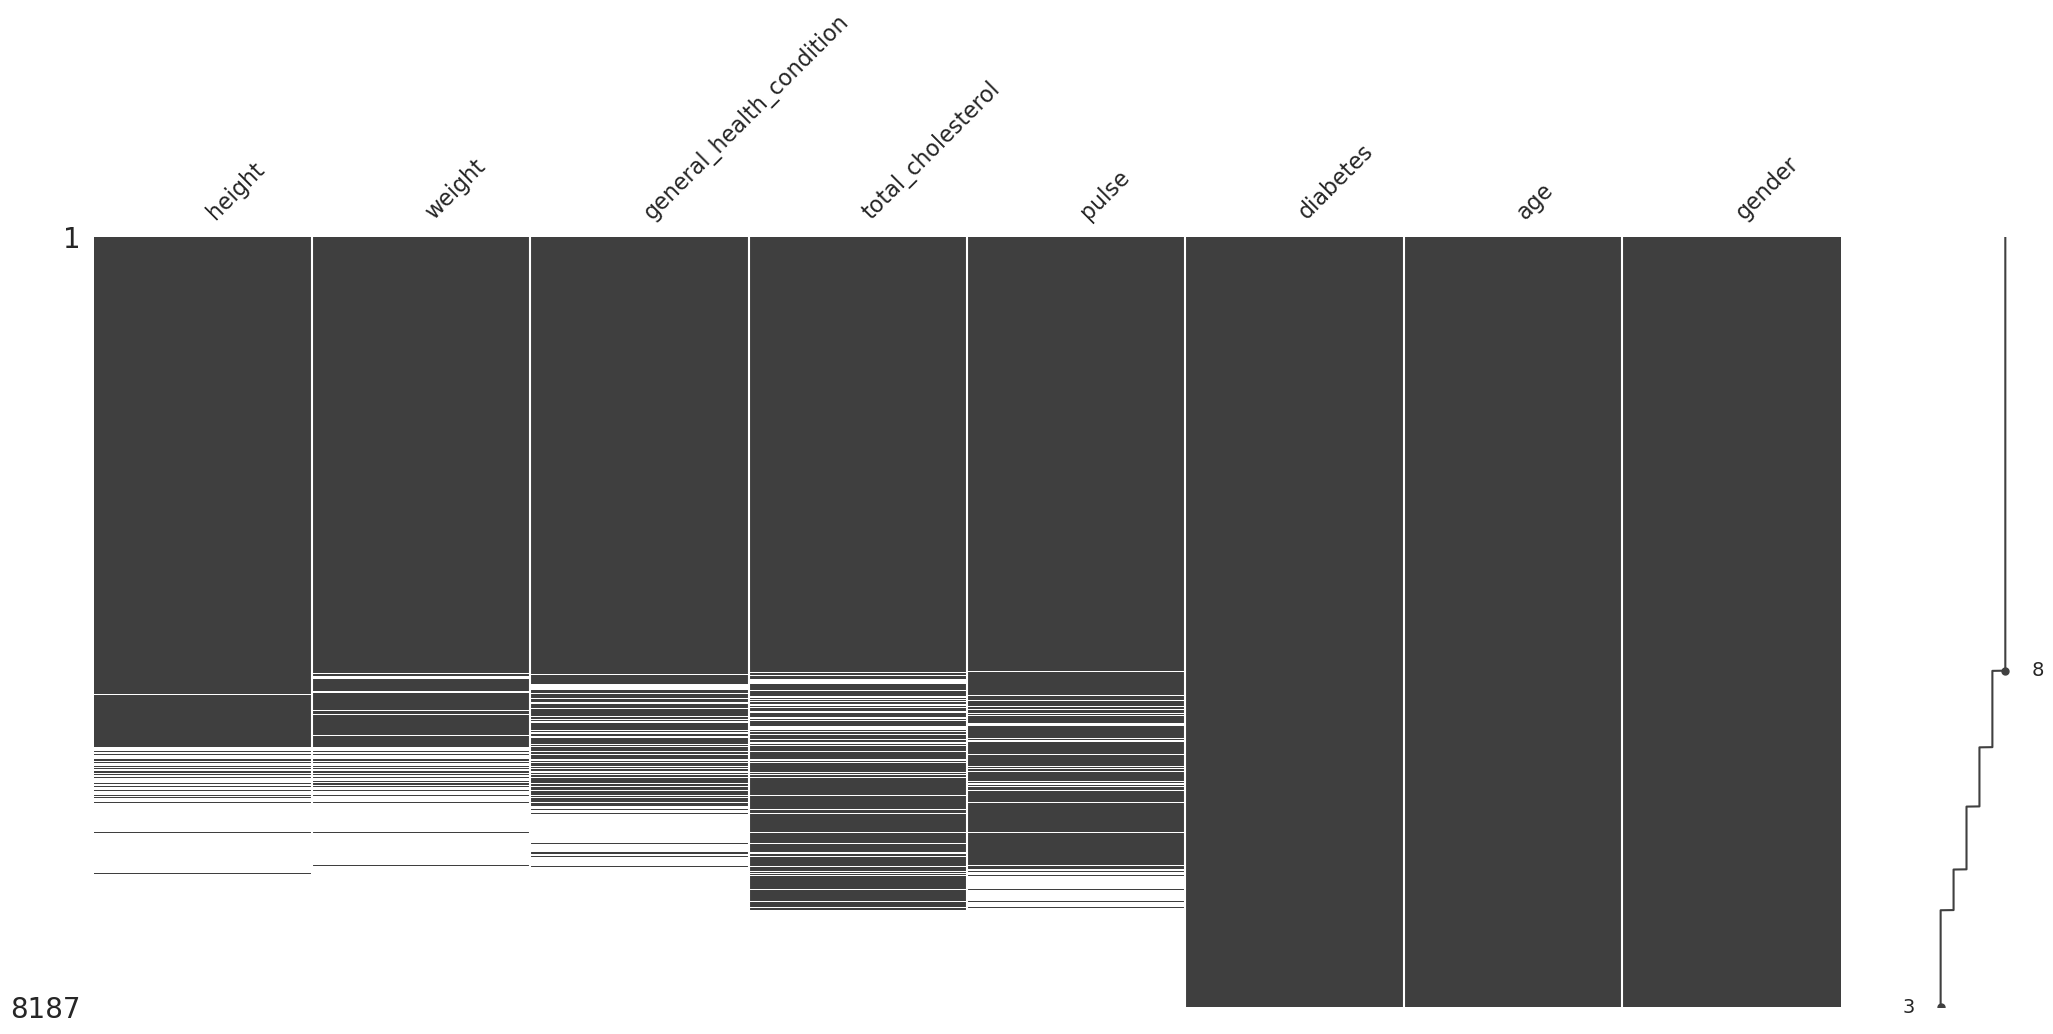

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e' '#0000002e'
 'black' 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' 'black' '#0000002e' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 'black' '#0000002

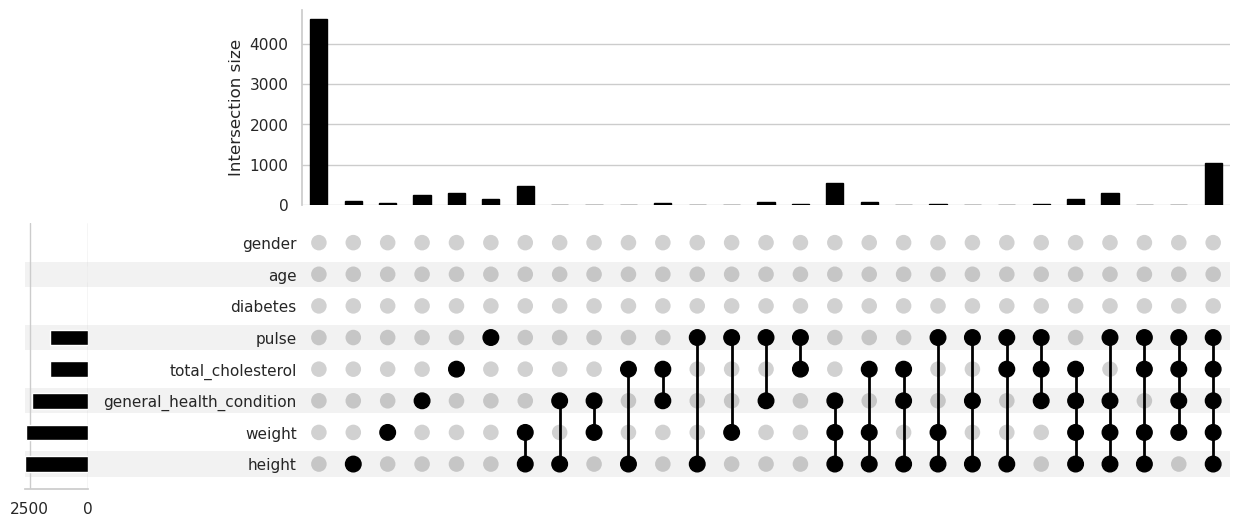

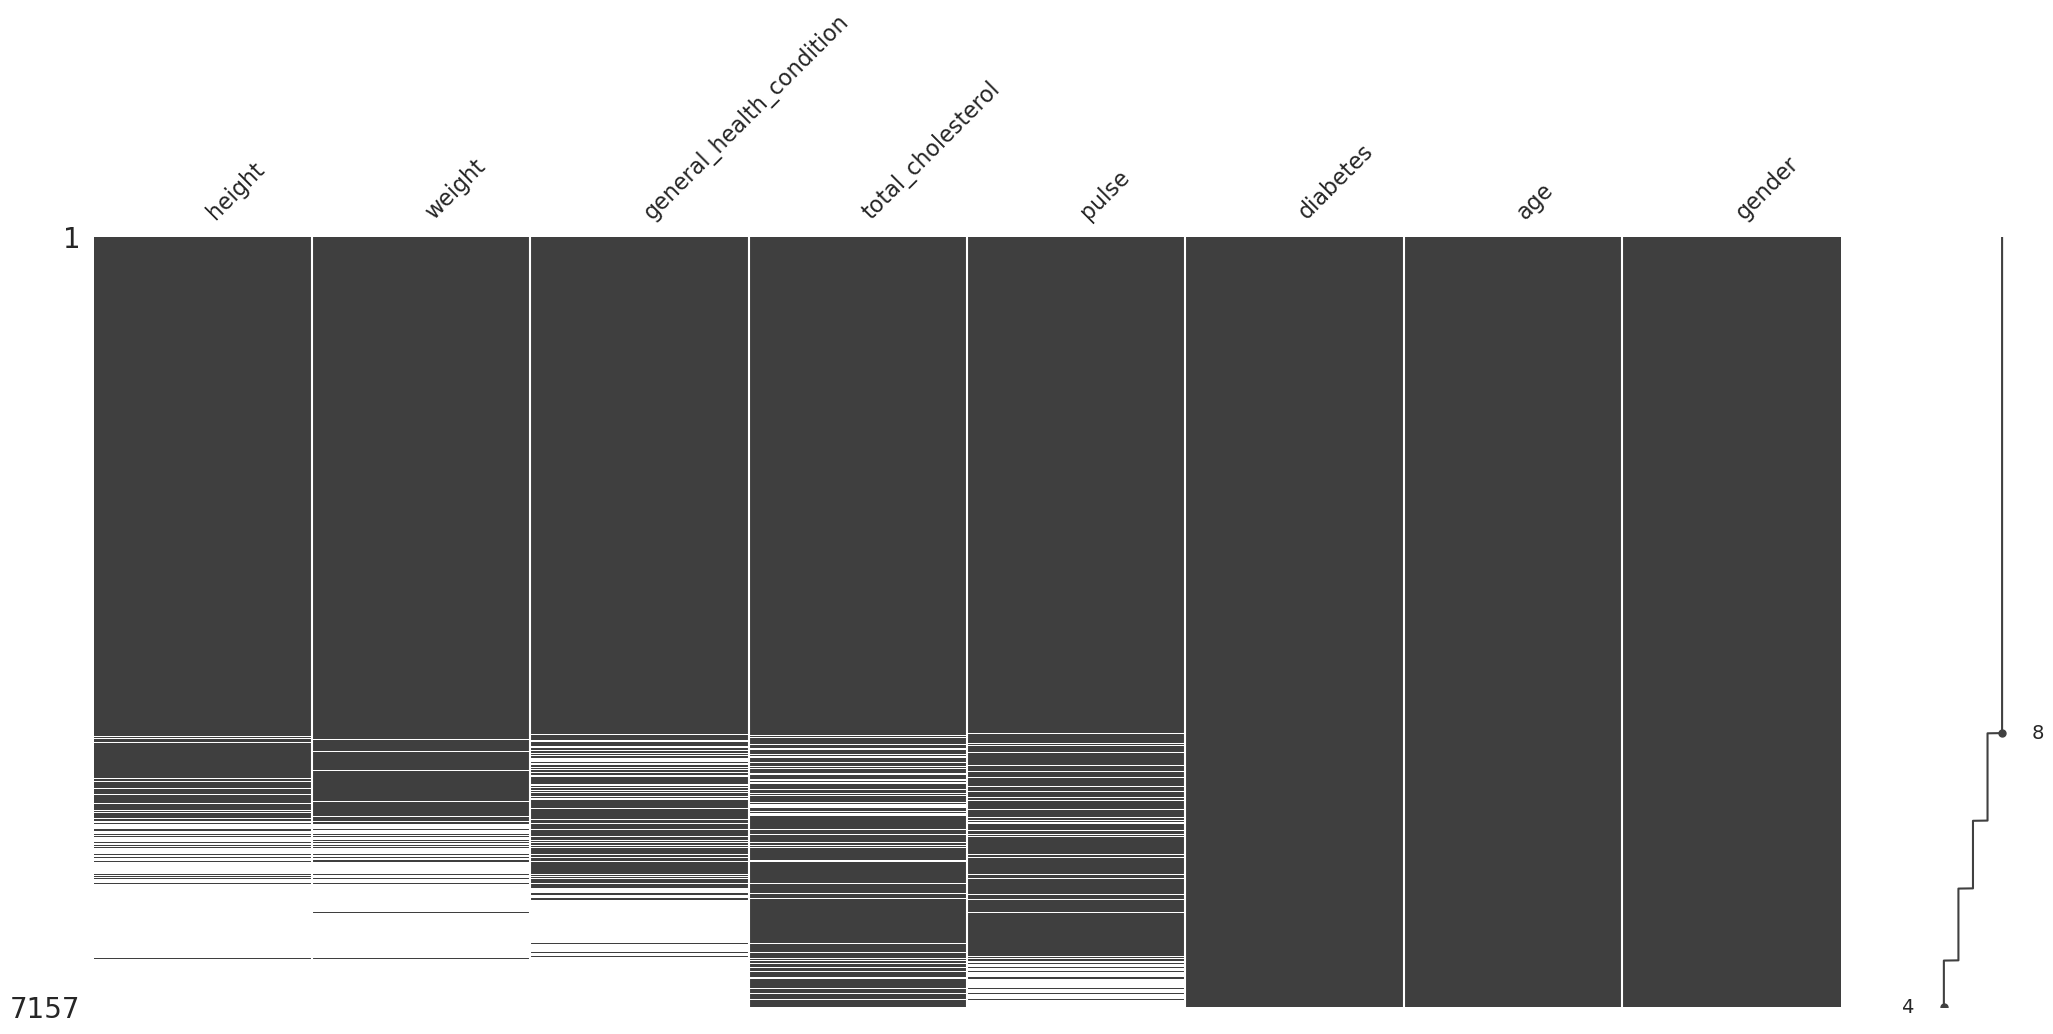

In [230]:
%run download-data-and-load-it.ipynb

## Evaluación del mecanismo de valores faltantes por prueba de t-test

📘 Información
   

    


        
two-sided: las medias de las distribuciones subyacentes a las muestras son desiguales.
        

        
less: la media de la distribución subyacente a la primera muestra es menor que la media de la distribución subyacente a la segunda muestra.
        

        
greater: la media de la distribución subyacente a la primera muestra es mayor que la media de la distribución subyacente a la segunda muestra.

In [231]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight", 
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male"),
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)


#A ver, la interpretación del profesor esta mal en todo aspecto, estadísticamente si rechazas "no rechazas la hipotesis nula" quiere decir que hay igualdad de medias por lo que la interpretacion correcta es que "no hay diferencias"
#Sin embargo realizar una prueba t de student así sin mas es algo que estadísticamente esta muy mal hecho, porque para empezar los dataframes tienen mas de 30 observaciones (filas) por lo que se deberia usar una prueba Z en lugar de t de student, las pruebas t de student son para muestras pequeñas (menores a 30)
#por otro lado para utilizar una prueba t o Z se debe verificar que las muestras (en este caso los dataframes) se distribuyan normal, que se cumpla el supuesto de homocedaticidad (que tengan igual varianza)
#N conclusión, a nivel de código y experiencia empirica los profesores de PLATZI son muy buenos, sin embargo les falta el componente estadístico, simplemente aplican cosas estadisticas y ya sin conocer la teoria que esta detras de todo.
#Soy estudiante de 8vo semestre de estadística y en muchos cursos he visto a los profesores cometer errores conceptuales y aplicar metodos de forma incorrecta.

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

## AMpl,ía  tu conjunto de herramientas para explorar valores faltantes

In [232]:
#Vamos a explorar la relaci,ón de variables categoricoas (health condition y gender) 
#en cuestion de la ausencia de otra variable (weight)
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
)

,weight,general_health_condition,gender
SEQN,,,
93705.0,!NA,Good,Female
93706.0,!NA,Very good,Male
93707.0,NA,Good,Male
93709.0,!NA,NaN,Female
93711.0,!NA,Very good,Male
...,...,...,...
102949.0,!NA,Excellent,Male
102953.0,!NA,Fair or,Male
102954.0,!NA,Good,Female


In [233]:
#Vamos a explorar la relaci,ón de variables categoricoas (health condition y gender) 
#en cuestion de la ausencia de otra variable (weight)
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby( #cuantificamos cuantas apariciones tenemos por cada una de las tres columnas
        ["gender", "general_health_condition", "weight"],
        dropna=False,
        as_index = True
    )
    .size()
)

gender  general_health_condition  weight
Female  Excellent                 !NA        212
                                  NA          65
        Fair or                   !NA        549
                                  NA          42
        Good                      !NA       1102
                                  NA         113
        Poor?                     !NA         94
                                  NA           3
        Very good                 !NA        659
                                  NA         103
        NaN                       !NA        234
                                  NA         489
Male    Excellent                 !NA        273
                                  NA          62
        Fair or                   !NA        508
                                  NA          31
        Good                      !NA       1056
                                  NA         112
        Poor?                     !NA         70
                            

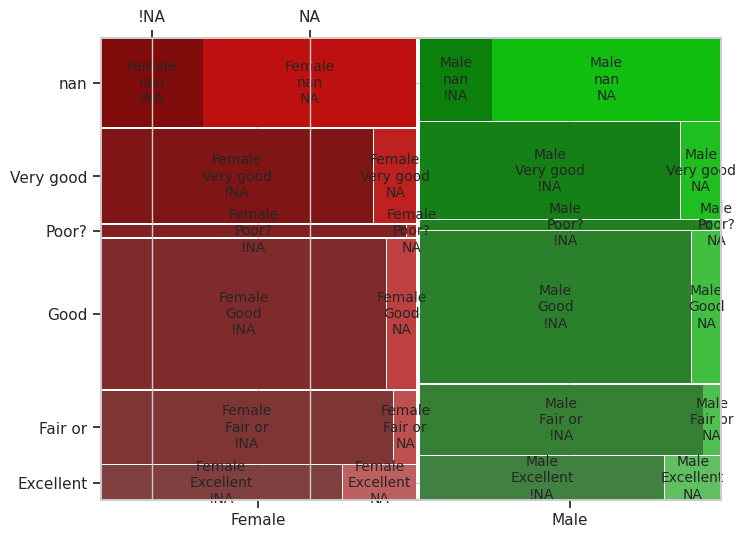

In [234]:
#Vamos a explorar la relaci,ón de variables categoricoas (health condition y gender) 
#en cuestion de la ausencia de otra variable (weight)
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby( #cuantificamos cuantas apariciones tenemos por cada una de las tres columnas
        ["gender", "general_health_condition", "weight"],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe( #Graficamos en mosaico
        lambda df: mosaic(
            data = df
        )
    )
);

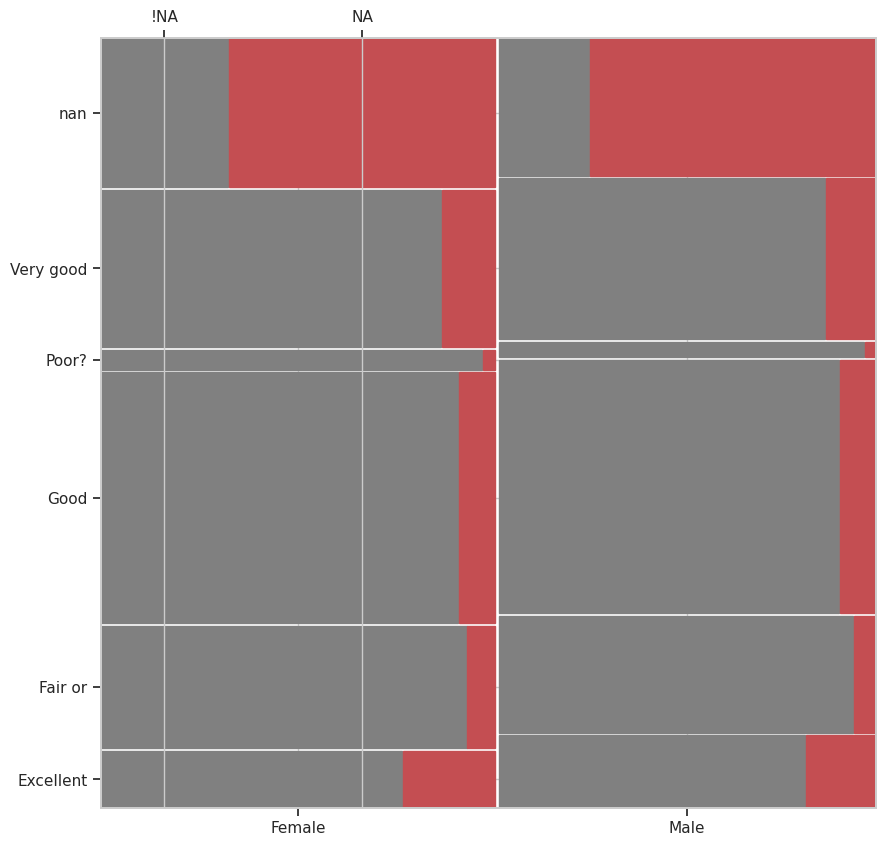

In [235]:
#Vamos a explorar la relaci,ón de variables categoricoas (health condition y gender) 
#en cuestion de la ausencia de otra variable (weight)

fig, ax = plt.subplots(figsize = (10, 10))
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby( #cuantificamos cuantas apariciones tenemos por cada una de las tres columnas
        ["gender", "general_health_condition", "weight"],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe( #Graficamos en mosaico
        lambda df: mosaic(
            data = df,
            properties = lambda key: {"color": "r" if "NA" in key else "gray"},  #personalizamos gr,áfica
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key:"",
            ax = ax
        )
    )
);

### Reto clase crear funcion missing.mosaic_plot en el archivo pandas-missing-extension.ipynb y llamar funcion

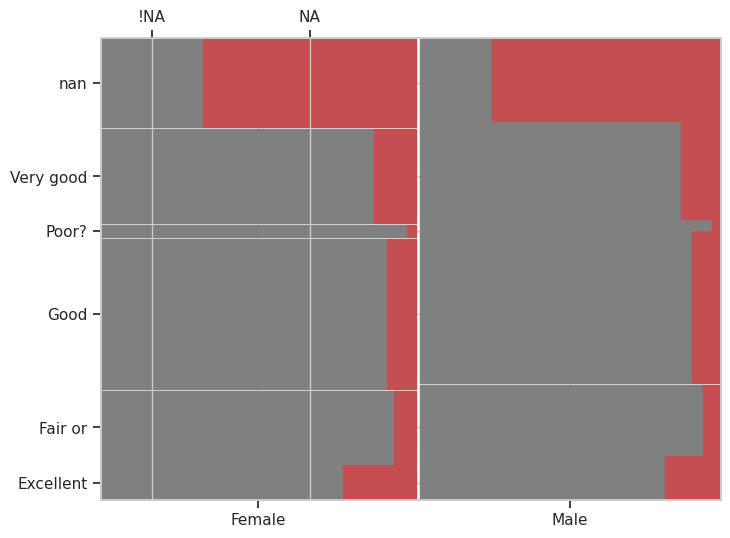

In [236]:
(
    nhanes_df
    .missing
    .missing_mosaic_plot(
        "weight",
        "general_health_condition",
        "gender"
    )
);



## Tratamiento de variables categoricas para imputacion de valores faltantes

In [237]:
#creamos copia del data frame, para no mpodificar el original
nhanes_transformed_df = nhanes_df.copy(deep = True) #deep = True tengan posici,ón de memoria distinta

### Codificacion ordinal
Mapea cada eqtiqueta (categoria) unica a un valor entero.  SE conoce como codificacion entera.

#### Ejemplo

In [238]:
X = [["Male"],["Female"],["Female"]]    #creamos arreglo

In [239]:
encoder = sklearn.preprocessing.OrdinalEncoder()    #guardamos en variable funcion codificador de scikitlearn

encoder.fit_transform(X)    # fit_transoform transforma los datos y los ajusta

array([[1.],
       [0.],
       [0.]])

In [240]:
encoder.categories_ #mostramos las categorias que tenemos

[array(['Female', 'Male'], dtype=object)]

In [241]:
#obtendremos lo contrario de la codificacion 
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

### Aplicando la cidificacion ordinal a todas las variables categoricas de un df

In [242]:
#del df obtenemos las variables categopricas y tipo objeto
nhanes_df.select_dtypes(include=[object, "category"])

,general_health_condition,gender
SEQN,,
93705.0,Good,Female
93706.0,Very good,Male
93707.0,Good,Male
93709.0,NaN,Female
93711.0,Very good,Male
...,...,...
102949.0,Excellent,Male
102953.0,Fair or,Male
102954.0,Good,Female


In [243]:
#del df obtenemos las variables categopricas y tipo objeto
# pero solo obtenemos sus nombres, no los valores
 #y lo guardamso en una variable
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [244]:
# Hacemos uso de funci,ón para componer instrucciones de transoformacion de datos
sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [245]:
# Hacemos uso de funci,ón para componer instrucciones de transoformacion de datos
#lo asignamos a una variable
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [246]:
#guardamos en un nuevo df lo transformado de nhanes_df
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df)
    )

)

,0,1,2,3,4,5,6,7
0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
7152,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,NaN,NaN,150.0,74.0,0.0,14.0


In [247]:
#guardamos en un nuevo df lo transformado de nhanes_df
# rreasignamos nuevamente losnombres de las columnas
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out()
    )
)

,ordinalencoder__general_health_condition,ordinalencoder__gender,remainder__height,remainder__weight,remainder__total_cholesterol,remainder__pulse,remainder__diabetes,remainder__age
0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
3,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
7152,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,NaN,NaN,150.0,74.0,0.0,14.0


In [248]:
#guardamos en un nuevo df lo transformado de nhanes_df
# rreasignamos nuevamente losnombres de las columnas
# quitamos prefijos ordialencoder y reminder a nombres de columnas, variables.
# y asignamos index
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


## OneHot Encoding

#### pandas.get_dummies() vs skelearn.preprocessing.OneHotEncoder()

In [249]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

##### pandas.get_dummies()

In [250]:
(
    nhanes_transformed_df2
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [251]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
)

,general_health_condition
SEQN,
93705.0,Good
93706.0,Very good
93707.0,Good
93709.0,NaN
93711.0,Very good
...,...
102949.0,Excellent
102953.0,Fair or
102954.0,Good


In [252]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


In [253]:
# si mediante pandas solo escogemos las 10 variables categoricas de nuestro df
# no va  a mostrar todas las 10 var categoricas
# tampoco muestra los valores faltantes, no muestra columna para indicar si se tienen valores faltantes
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .head(10)
    .pipe(pd.get_dummies)
)

,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Very good
SEQN,,,
93705.0,False,True,False
93706.0,False,False,True
93707.0,False,True,False
93709.0,False,False,False
93711.0,False,False,True
93712.0,False,True,False
93713.0,False,False,True
93714.0,False,True,False
93715.0,True,False,False


##### OneHot encoding con skelearn

In [254]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [255]:
# quitamos prefijos onehotencoder, ordnialencoder y reminder a nombres de columnas, variables.
# y asignamos index
nhanes_transformed_df2 = (
    pd.DataFrame(
       transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder")
    )
)

nhanes_transformed_df2

,gender,__general_health_condition_Excellent,__general_health_condition_Fair or,__general_health_condition_Good,__general_health_condition_Poor?,__general_health_condition_Very good,__general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [256]:
# accedemos a  las categorias
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [257]:
# obtenemos la invers, le pasamos lista de n,úmeros
# mediante arreglo de 6 n,úmeros nos muestra que categoria representa.
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 0, 1, 0, 0]]
    )
)

array([['Poor?']], dtype=object)

# Tipos de imputaci,ón de valores faltantes

### Imputacion de un unico valor (media, mediana, moda)

In [258]:
#imputacion de datos faltantes con el promedio mean
(
    nhanes_df
    # janitor
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise= False
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.00000,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.00000,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,66.25656,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.00000,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.00000,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.00000,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.00000,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.00000,150.0,Good,172.0,78.0,0,41.0,Female


In [259]:
#imputacion de datos faltantes con el promedio mean
(
    nhanes_df
    # janitor
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise= False
    )
    .height #solo visualizamos columna
    .mean()     #solo visualizamos promedio de columna height
)

66.25655976676386

In [260]:
#creamos matriz xombra shadow matrix
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
)

,height,weight,height_imp,weight_imp
SEQN,,,,
93705.0,63.0,165.0,False,False
93706.0,68.0,145.0,False,False
93707.0,NaN,NaN,True,True
93709.0,62.0,200.0,False,False
93711.0,69.0,142.0,False,False
...,...,...,...,...
102949.0,72.0,180.0,False,False
102953.0,65.0,218.0,False,False
102954.0,66.0,150.0,False,False


In [261]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean()),
    )
)

,height,weight,height_imp,weight_imp
SEQN,,,,
93705.0,63.00000,165.000000,False,False
93706.0,68.00000,145.000000,False,False
93707.0,66.25656,178.462993,True,True
93709.0,62.00000,200.000000,False,False
93711.0,69.00000,142.000000,False,False
...,...,...,...,...
102949.0,72.00000,180.000000,False,False
102953.0,65.00000,218.000000,False,False
102954.0,66.00000,150.000000,False,False


/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='height', ylabel='weight'>

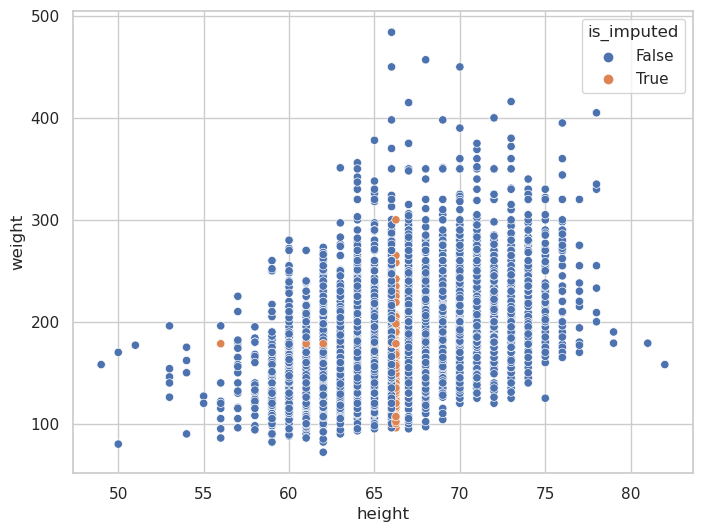

In [262]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
#graficamos
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight"
    )
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

<Axes: xlabel='height', ylabel='weight'>

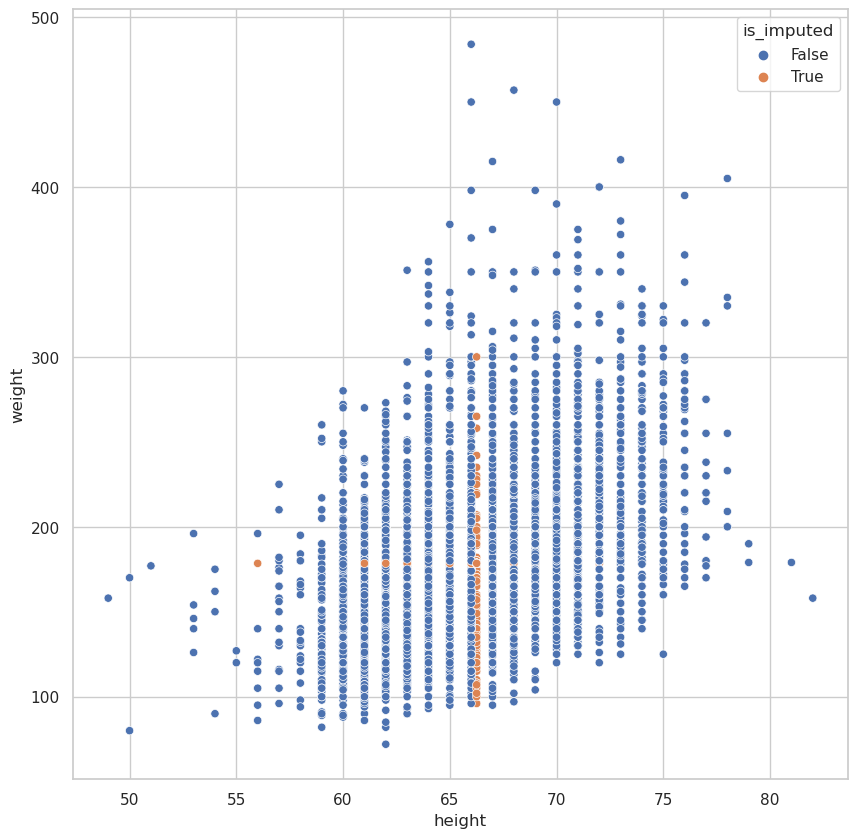

In [264]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
#graficamos
#hacemos m,ás grande el tamaño de la grafica
plt.figure(figsize=(10,10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight"
    )
)

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

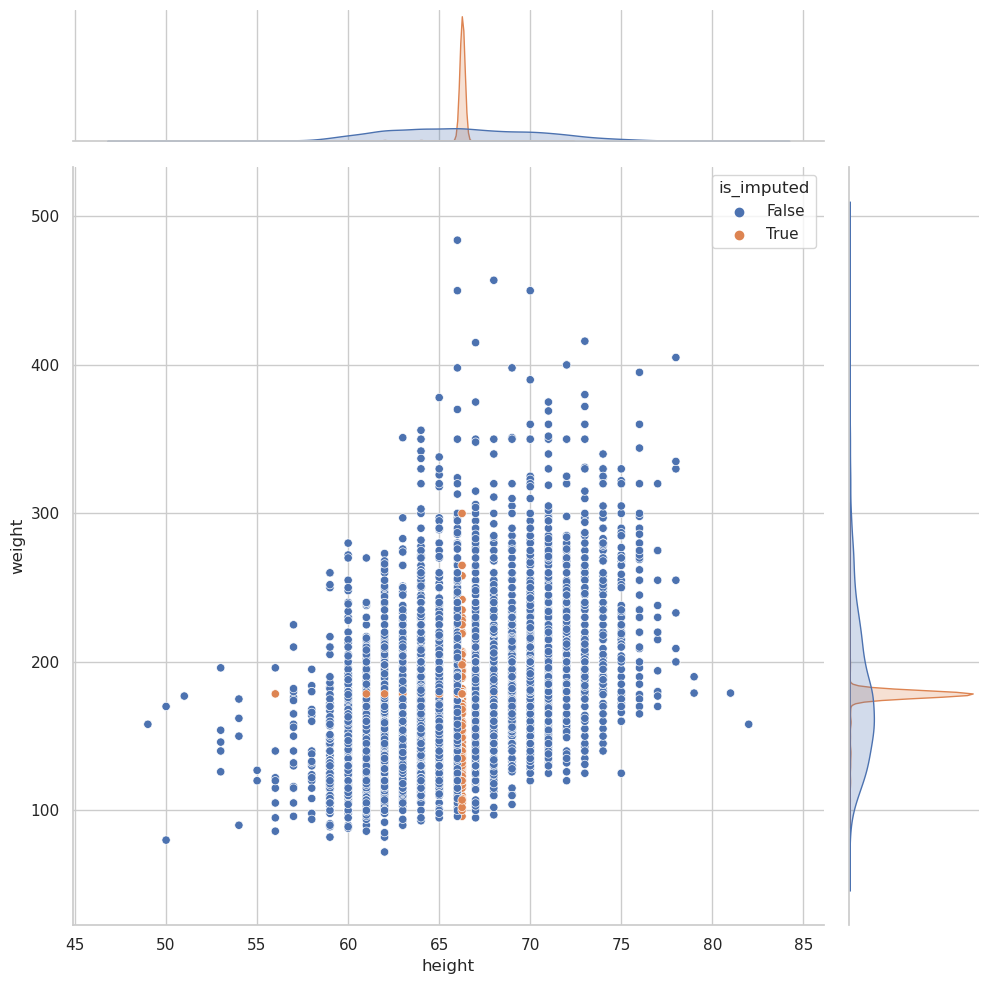

In [265]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
#graficamos
#hacemos m,ás grande el tamaño de la grafica
#miramos como se est,á modificando la fistribucion


(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal = True,
        height = 10
    )
)

#### Reto imputar con la mediana

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

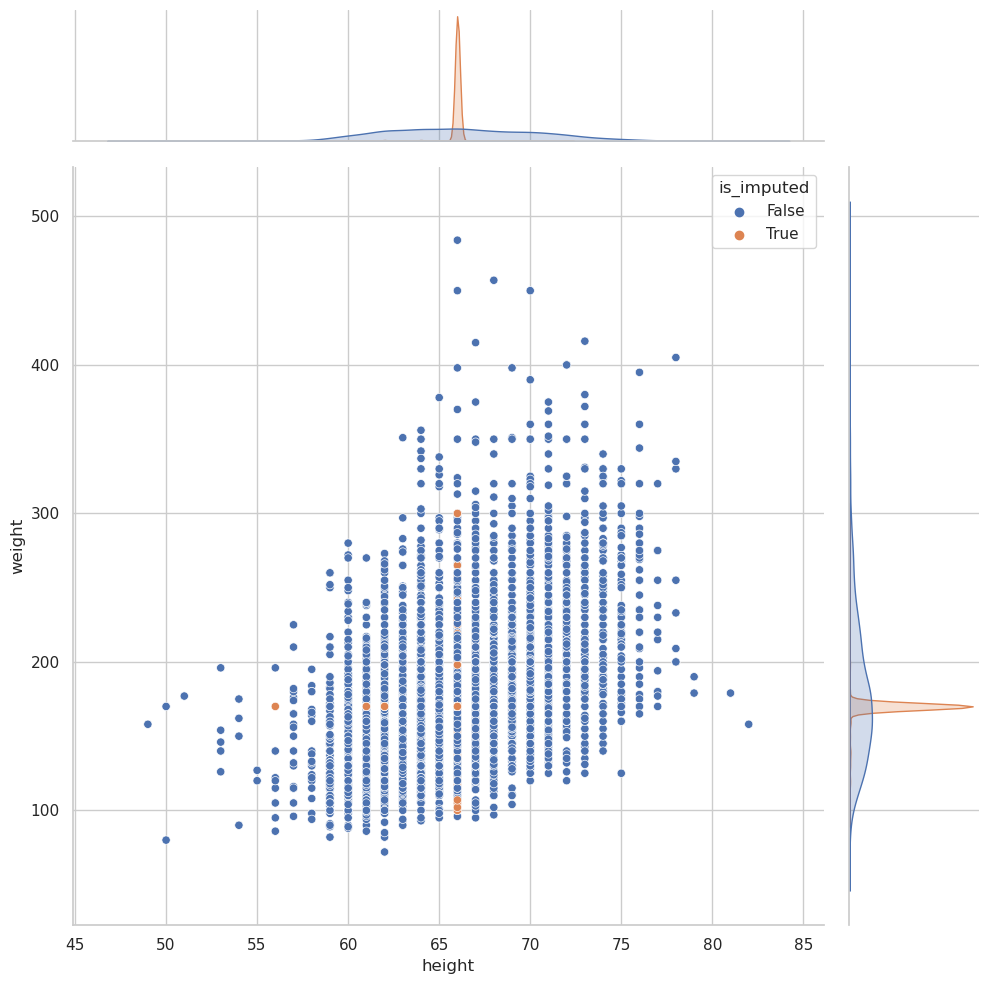

In [266]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
#graficamos
#hacemos m,ás grande el tamaño de la grafica
#miramos como se est,á modificando la fistribucion


(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal = True,
        height = 10
    )
)

#### reto imputar con la moda 

/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jam/anaconda3/envs/datos_faltantes_impu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

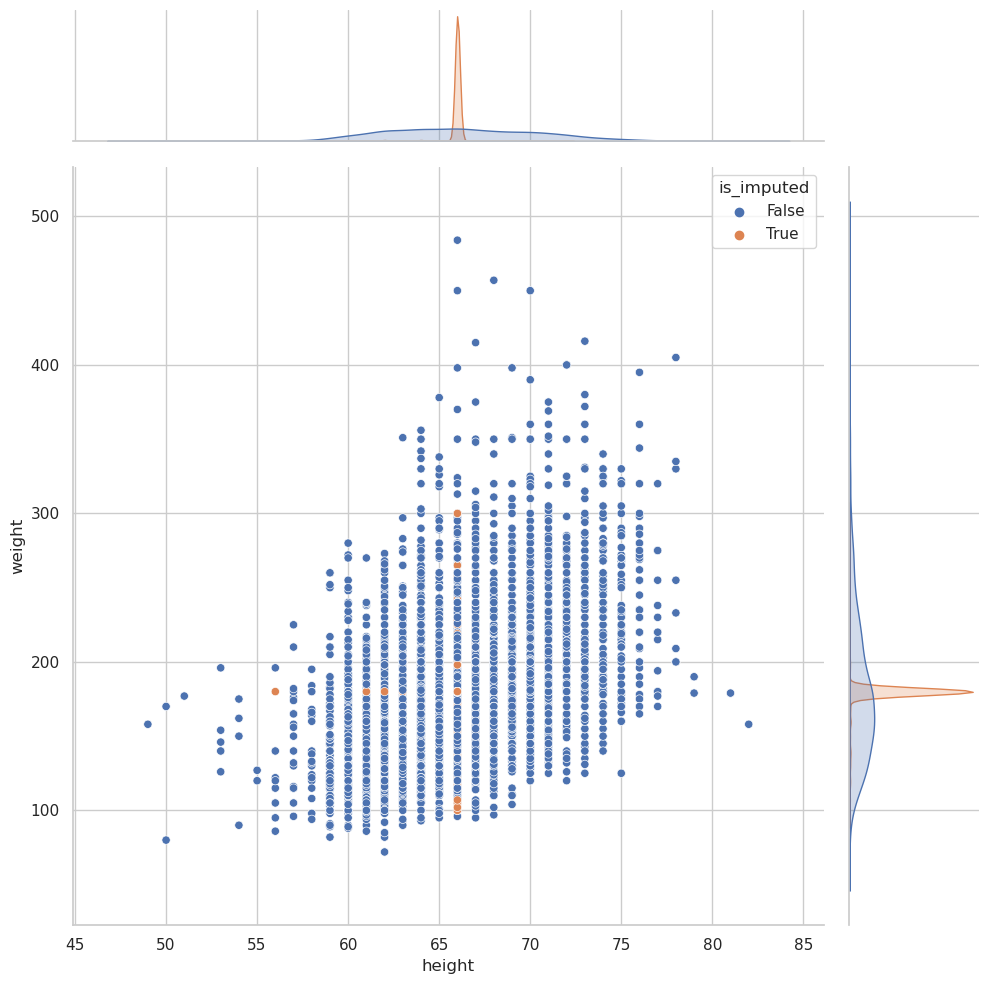

In [268]:
#creamos matriz xombra shadow matrix
#asignamos editamos el valor de las variables
#graficamos
#hacemos m,ás grande el tamaño de la grafica
#miramos como se est,á modificando la fistribucion


(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode().values[0]),
        weight = lambda df: df.weight.fillna(value = df.weight.mode().values[0]),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal = True,
        height = 10
    )
)

# Imputacion por llenado hacia atras e imputacion por llenado hacia adelante

#### fillna() vs ffill() o bfill()

In [272]:
#aplicamos metodo imputacion forward fill ffill

(
    nhanes_df
    .select_columns("height", "weight")
    .fillna(method = "ffill")
)

/tmp/ipykernel_5264/3654692552.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nhanes_df


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [273]:
#aplicamos metodo imputacion forward fill ffill
#ahora de manera abreviada

(
    nhanes_df
    .select_columns("height", "weight")
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [274]:
#aplicamos metodo imputacion forward fill ffill
#ahora de manera abreviada

(
    nhanes_df
    .select_columns("height", "weight")
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


### Recomendaciones al imputar valores utilizando ffill() o bfill()
##### Imputacion dentro de dominios e imputacion a traves de variables correlacionadas

In [275]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


##### reto

In [276]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .groupby(
        ["gender", "general_health_condition"],
        dropna=False
    )
    .apply(lambda x: x.ffill())
)

height  weight  gender  diabetes  \
gender general_health_condition SEQN                                        
Female Excellent                94421.0    56.0   115.0  Female         0   
                                94187.0    59.0   130.0  Female         0   
                                95289.0    59.0   162.0  Female         0   
                                97967.0    59.0   130.0  Female         0   
                                99125.0    59.0   105.0  Female         0   
...                                         ...     ...     ...       ...   
Male   NaN                      96561.0    74.0   290.0    Male         1   
                                96954.0    74.0   175.0    Male         1   
                                97267.0    74.0   175.0    Male         1   
                                97856.0    74.0   175.0    Male         1   
                                98317.0    74.0   175.0    Male         1   

                                        general_health_condition  
gender general_health_condition SEQN                              
Female Excellent                94421.0                Excellent  
                                94187.0                Excellent  
                                95289.0                Excellent  
                                97967.0                Excellent  
                                99125.0                Excellent  
...                                                          ...  
Male   NaN                      96561.0                      NaN  
                                96954.0                      NaN  
                                97267.0                      NaN  
                                97856.0                      NaN  
                                98317.0                      NaN  

[7157 rows x 5 columns]